/usr/local/lib/python3.10/dist-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


binning: b'1x1'
exposure_time_us: 100000.8
readout_speed: 2.0
roiheight: 400.0
roioffsetx: 1900
roioffsety: 1000
roiwidth: 400.0
Acquring atom locations


/home/winklmann/.local/lib/python3.10/site-packages/skimage/transform/radon_transform.py:75: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


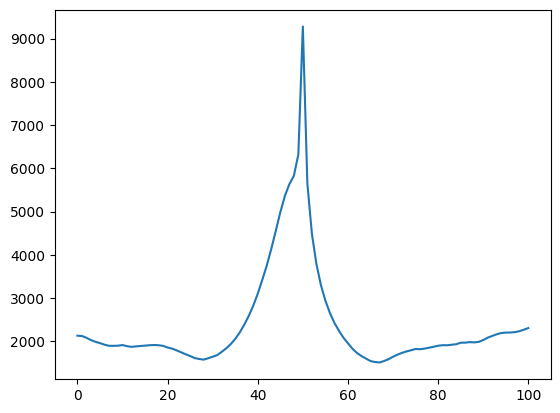

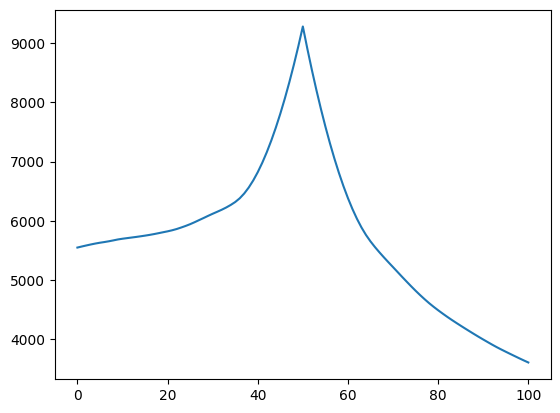

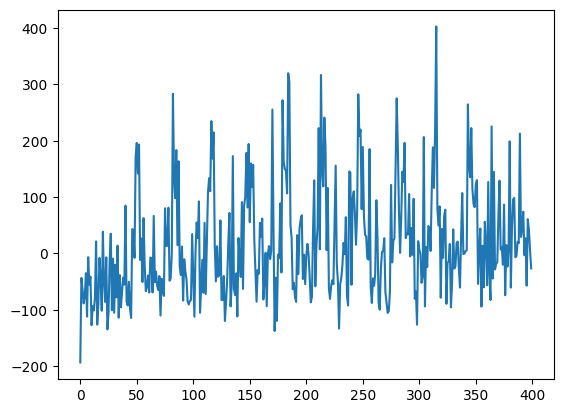

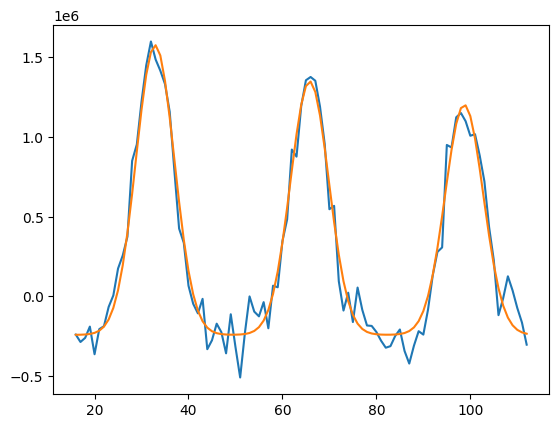

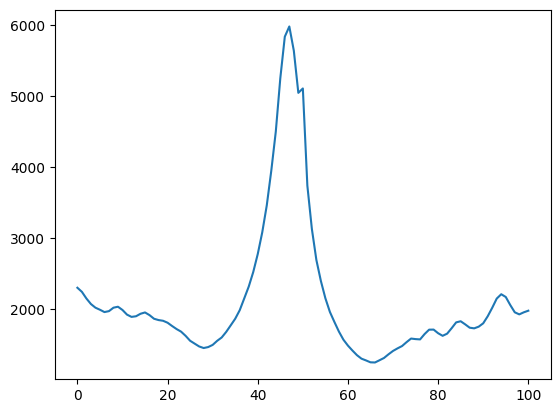

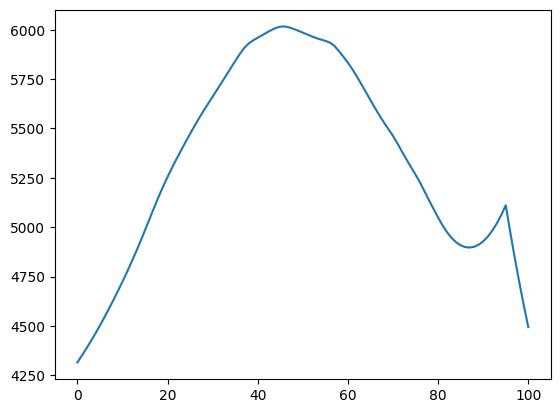

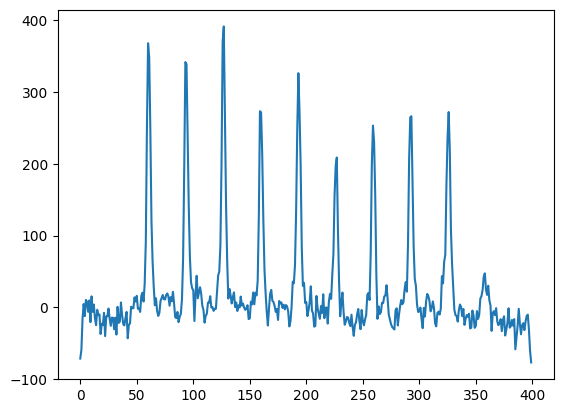

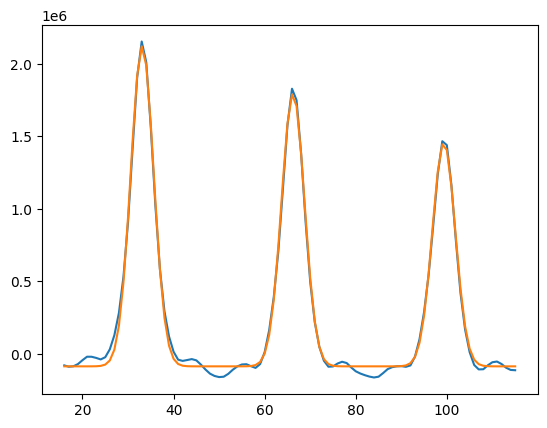

Acquring PSF
Full scale PSF: 


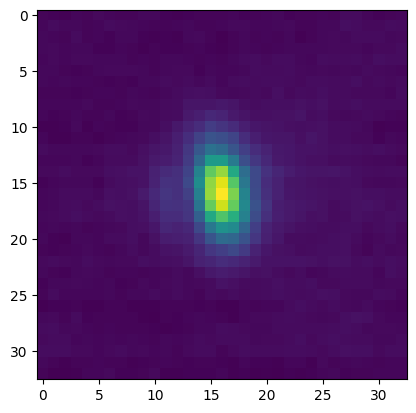

|########################################| 1/1, 0s                             
Loaded from cache file
Integrated projector(s):


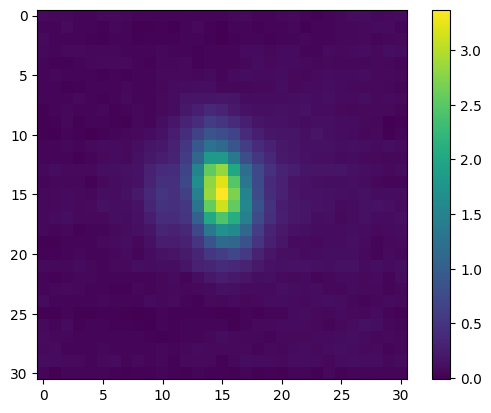

Creating C++ object
All images reconstructed within 135.853ms
Threshold: 35233.86804931413
F0: 0.9997887031693455
F1: 0.9985054534933391
F: 0.9993914948674261
Calibration finished, total time: 3531.046ms


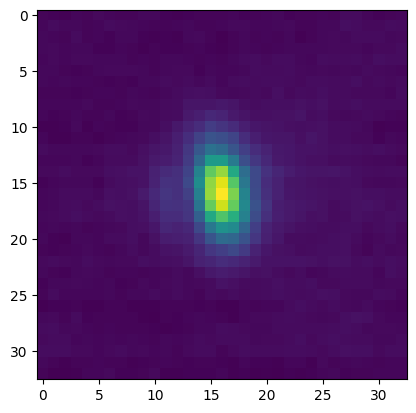

Average time (us): 506.20318021201416


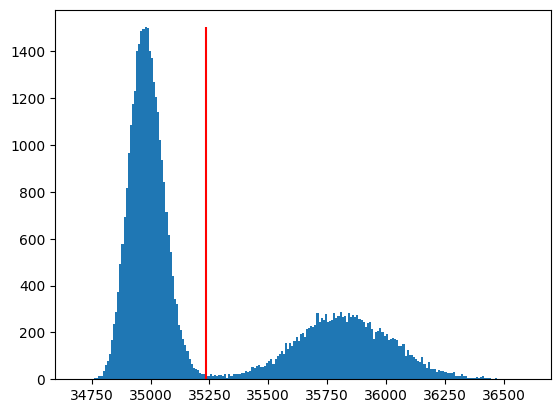

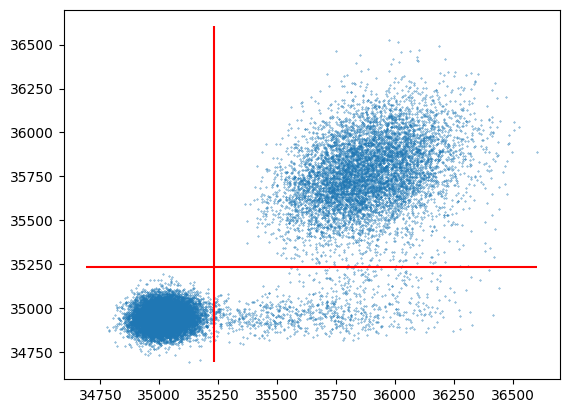

In [1]:
import os
from neutral_atom_image_analysis import ImageAnalysisProjection

import matplotlib.pyplot as plt
import h5py

from datetime import datetime

import numpy as np

camera = 'orca0'
path_closed_shutter = "../../mpq_image_data/Lattice_CMOS_Dataset/closedShutter/data_3_images_100ms_exptime/"
directory_closed_shutter = os.fsencode(path_closed_shutter)
first = True
image_count = 0
for file in os.listdir(directory_closed_shutter):
    filename = os.fsdecode(file)
    with h5py.File(path_closed_shutter + filename) as f:
        for i in f.get(camera).keys():
            if first:
                metadata = f.get(camera + '/' + i + '/metadata')
                for key in metadata.keys():
                    value = str(metadata[key][()])
                    print(key + ": " + value)
                    if key == "roiwidth":
                        width = int(float(value))
                    if key == "roiheight":
                        height = int(float(value))
                loc_image = np.zeros((height,width))

            data = np.array(f.get(camera + '/' + i + '/data'))

            if(len(data) > 0):
                image_count += 1
                if first:
                    closed_shutter_average = data.astype(np.float64)
                    first = False
                else:
                    closed_shutter_average += data
closed_shutter_average = closed_shutter_average / image_count

path = "../../mpq_image_data/Lattice_CMOS_Dataset/01_tweezers_newcamera/003_histogram/data/"
directory = os.fsencode(path)
images = []
image_pairs = []
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    with h5py.File(path + filename) as f:
        image_pair = []
        for i in f.get(camera).keys():
            data = np.array(f.get(camera + '/' + i + '/data'))
            if(len(data) > 0):
                image_pair.append(data.copy())
                images.append(data.copy())
        if len(image_pair) == 2:
            image_pairs.append(image_pair)
    
iap = ImageAnalysisProjection(1, print_info=True)
threshold, peaks, fidelity, fidelity0, fidelity1, calibration_filling_ratio, measured_filling_ratio = iap.calibrate(images[:50], closed_shutter_average, proj_shape=[31,31])

plt.imshow(iap.psf)
plt.show()

parameters = []
parameters_2d_first = []
parameters_2d_second = []
start_time = datetime.now()
for image1, image2 in image_pairs[25:]:
    result1 = iap.reconstruct(image1)
    result2 = iap.reconstruct(image2)
    parameters.extend(result1)
    parameters.extend(result2)
    parameters_2d_first.extend(result1)
    parameters_2d_second.extend(result2)
end_time = datetime.now()
print("Average time (us): " + str((end_time - start_time).microseconds / 2 / len(image_pairs)))

count, _, _ = plt.hist(parameters, int(np.sqrt(len(parameters))))
plt.vlines([threshold], ymin=0, ymax=np.max(count), colors=['red'])
plt.show()
plt.scatter(parameters_2d_first, parameters_2d_second, s=0.1)
plt.vlines([threshold], ymin=np.min(parameters), ymax=np.max(parameters), colors=['red'])
plt.hlines([threshold], xmin=np.min(parameters), xmax=np.max(parameters), colors=['red'])